# RNR - Nivel de Planta

In [341]:
#Importar librerias
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import modulo_conn_sql as mcq
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from pickle import dump
from pickle import load

def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)


In [111]:
#PRINCIPAL

############################################# PARAMETROS #############################################
pais = 'Colombia'
inicioHistoria = datetime.datetime(2014, 1, 1) #'2013-05-01'
finHistoria = datetime.datetime(2022, 4 , 18)


######################################### CONSULTA BD #############################################

#Consulta de datos en la base SQL
despachosSQL = querySQL(  "{CALL SCAC_AP8_BaseForecast (?,?,?)}", (pais, inicioHistoria.strftime("%Y-%m-%d"), finHistoria.strftime("%Y-%m-%d") ) )

nombre_cluster = querySQL( "SELECT Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as PlantaUnica FROM SCAC_AT1_NombreCluster where Pais = ? and Activo = 1" , (pais) )

################################### PRE-PROCESAMIENTO DE LOS DATOS #############################################

df = pd.merge(despachosSQL, nombre_cluster, left_on='Planta', right_on='Centro')
df1 = df.groupby(['PlantaUnica','FechaEntrega']).agg({'totalEntregado': 'sum'}).reset_index()

df1['DiaSemana'] = df1['FechaEntrega'].dt.dayofweek
df1['año'] = df1['FechaEntrega'].dt.year

################################### Estructura RNR #############################################

fecha_split = '2022-03-15'
#Memoria corto plazo
timesteps = 15
#numero de neuronas
un = 120
#coeficiente de olvido
do = 0.05
#numero de ciclos
ep = 1100



In [112]:
df1.PlantaUnica.unique()

array(['CO-CXO - GARZÓN', 'CO-PLANTA 240', 'CO-PLANTA BARRANQUILLA',
       'CO-PLANTA BELLO', 'CO-PLANTA BOSA', 'CO-PLANTA CALI',
       'CO-PLANTA CALI SUR', 'CO-PLANTA CALLE 170', 'CO-PLANTA CARTAGENA',
       'CO-PLANTA CON. IBAGUE', 'CO-PLANTA CUCUTA', 'CO-PLANTA Canoas',
       'CO-PLANTA FLORIDA', 'CO-PLANTA FONTIBÒN', 'CO-PLANTA FUSA',
       'CO-PLANTA LA FELICIDAD', 'CO-PLANTA La Reforma',
       'CO-PLANTA MACEO', 'CO-PLANTA MASSEQ', 'CO-PLANTA MEDELLIN',
       'CO-PLANTA NEIVA', 'CO-PLANTA NOVATERRA', 'CO-PLANTA PAMPLONA',
       'CO-PLANTA PEREIRA', 'CO-PLANTA PRDS MDRD PALMAR MXRS',
       'CO-PLANTA PTAR', 'CO-PLANTA PUENTE ARANDA',
       'CO-PLANTA PUERTO BERRIO', 'CO-PLANTA Paraiso Central',
       'CO-PLANTA RIONEGRO', 'CO-PLANTA SANTA MARTA', 'CO-PLANTA SIBERIA',
       'CO-PLANTA SOACHA', 'CO-PLANTA SOPETRAN', 'CO-PLANTA SUMAPAZ',
       'CO-PLANTA SUR (DTE)', 'CO-PLANTA SURATA', 'CO-PLANTA TERRAGRATA',
       'CO-PLANTA TOCANCIPA', 'CO-PLANTA TULUA PARAJE LA RIVE

In [342]:
planta_target = 'CO-PLANTA BARRANQUILLA'


In [343]:
df_target = df1[df1['PlantaUnica']==planta_target]

dataset_array = df_target.iloc[: , 2:5].values

#Defino el dataset de entrenamiento y el de test
dataset_train = df_target[ df_target['FechaEntrega'] < fecha_split]
training_set  = dataset_train.iloc[: , 2:5].values

dataset_test = df_target[ df_target['FechaEntrega'] >= fecha_split ]
test_set  = dataset_test.iloc[: , 2:5].values

# Escalado de características
sc = MinMaxScaler(feature_range = (0, 1))
dataset_array_scaled = sc.fit_transform(dataset_array)
training_set_scaled = sc.transform(training_set)
test_set_scaled = sc.transform(test_set)

# Guardar el escalador
dump(sc, open("../datos/"+ planta_target + ".pkl", "wb"))

In [336]:
#ESTRUCTURA DE LA RED NEURONAL RECURRENTE

#defino un array por cada variable predictora
X_train = []
X_train_material = []
X_train_DiaSemana = []
X_train_SemanaRelativa = []
X_train_SemanaMes = []
X_train_Mes = []
X_train_Year = []
X_train_Irregularidad = []

y_train = []

for i in range(timesteps, len(training_set)):
    #columna 0 -> Cantidad Material
    X_train_material.append( training_set_scaled[i-timesteps:i, 0])
    
    #columna 1 -> DiaSemana
    X_train_DiaSemana.append( training_set_scaled[i-timesteps:i, 1])
    
    #columna 5 -> Year
    X_train_Year.append( training_set_scaled[i-timesteps:i, 2])
    

    y_train.append(training_set_scaled[i, 0])

#se convierten los array en objetos numpy    
X_train_material = np.array( X_train_material)
X_train_DiaSemana =  np.array(X_train_DiaSemana )
X_train_SemanaRelativa = np.array( X_train_SemanaRelativa)
X_train_SemanaMes = np.array(X_train_SemanaMes )
X_train_Mes = np.array(X_train_Mes )
X_train_Year = np.array( X_train_Year)
X_train_Irregularidad = np.array( X_train_Irregularidad)
y_train = np.array(y_train)

#Se agrega una nueva dimension a las variables
X_train_material = np.reshape(X_train_material, (X_train_material.shape[0], X_train_material.shape[1], 1 ))
X_train_DiaSemana = np.reshape(X_train_DiaSemana, (X_train_DiaSemana.shape[0], X_train_DiaSemana.shape[1], 1 ))
X_train_Year = np.reshape(X_train_Year, (X_train_Year.shape[0], X_train_Year.shape[1], 1 ))

#se crea el la estructura de datos que se le va a pasar al regresor
X_train = np.append(X_train_material, (X_train_DiaSemana), axis = 2 )
X_train = np.append(X_train, (X_train_Year), axis = 2 )

#inicializacion del regresor
regressor = Sequential()

#añadir la primera capa de LSTM y la regularización por Dropout
regressor.add(LSTM(units= un, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(do))

#regressor.add(LSTM(units=un, input_shape=(X_train.shape[1], X_train.shape[2])))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir penultima capa
regressor.add(LSTM(units=un))
regressor.add(Dropout(do))

#añadir capa de salida
regressor.add(Dense(units=1))

#compilar la RNR
regressor.compile(optimizer = 'adam', loss='mean_squared_error')

In [337]:
#ajustar la RNR al conjunto de entrenamiento
regressor.fit(X_train, y_train, epochs=ep, batch_size = 512)

Epoch 1/1100
5/5 [==============================] - 25s 423ms/step - loss: 0.1404
Epoch 2/1100
5/5 [==============================] - 2s 361ms/step - loss: 0.0342
Epoch 3/1100
5/5 [==============================] - 2s 349ms/step - loss: 0.0294
Epoch 4/1100
5/5 [==============================] - 3s 499ms/step - loss: 0.0250
Epoch 5/1100
5/5 [==============================] - 2s 478ms/step - loss: 0.0215
Epoch 6/1100
5/5 [==============================] - 2s 383ms/step - loss: 0.0198
Epoch 7/1100
5/5 [==============================] - 2s 401ms/step - loss: 0.0195
Epoch 8/1100
5/5 [==============================] - 2s 323ms/step - loss: 0.0198
Epoch 9/1100
5/5 [==============================] - 2s 345ms/step - loss: 0.0192
Epoch 10/1100
5/5 [==============================] - 2s 366ms/step - loss: 0.0187
Epoch 11/1100
5/5 [==============================] - 2s 362ms/step - loss: 0.0190
Epoch 12/1100
5/5 [==============================] - 2s 308ms/step - loss: 0.0191
Epoch 13/1100
5/5 [=====

Epoch 101/1100
5/5 [==============================] - 2s 324ms/step - loss: 0.0160
Epoch 102/1100
5/5 [==============================] - 2s 350ms/step - loss: 0.0167
Epoch 103/1100
5/5 [==============================] - 2s 340ms/step - loss: 0.0171
Epoch 104/1100
5/5 [==============================] - 2s 348ms/step - loss: 0.0167
Epoch 105/1100
5/5 [==============================] - 2s 339ms/step - loss: 0.0165
Epoch 106/1100
5/5 [==============================] - 2s 354ms/step - loss: 0.0170
Epoch 107/1100
5/5 [==============================] - 2s 339ms/step - loss: 0.0167
Epoch 108/1100
5/5 [==============================] - 2s 335ms/step - loss: 0.0161
Epoch 109/1100
5/5 [==============================] - 2s 325ms/step - loss: 0.0172
Epoch 110/1100
5/5 [==============================] - 2s 318ms/step - loss: 0.0163
Epoch 111/1100
5/5 [==============================] - 2s 321ms/step - loss: 0.0166
Epoch 112/1100
5/5 [==============================] - 2s 318ms/step - loss: 0.0162
Epoc

5/5 [==============================] - 2s 386ms/step - loss: 0.0166
Epoch 200/1100
5/5 [==============================] - 2s 389ms/step - loss: 0.0154
Epoch 201/1100
5/5 [==============================] - 2s 381ms/step - loss: 0.0160
Epoch 202/1100
5/5 [==============================] - 2s 409ms/step - loss: 0.0159
Epoch 203/1100
5/5 [==============================] - 2s 393ms/step - loss: 0.0163
Epoch 204/1100
5/5 [==============================] - 2s 400ms/step - loss: 0.0167
Epoch 205/1100
5/5 [==============================] - 2s 379ms/step - loss: 0.0154
Epoch 206/1100
5/5 [==============================] - 2s 349ms/step - loss: 0.0159
Epoch 207/1100
5/5 [==============================] - 2s 409ms/step - loss: 0.0167
Epoch 208/1100
5/5 [==============================] - 2s 361ms/step - loss: 0.0156
Epoch 209/1100
5/5 [==============================] - 2s 350ms/step - loss: 0.0163
Epoch 210/1100
5/5 [==============================] - 2s 350ms/step - loss: 0.0162
Epoch 211/1100
5/5 

5/5 [==============================] - 2s 317ms/step - loss: 0.0160
Epoch 298/1100
5/5 [==============================] - 2s 313ms/step - loss: 0.0154
Epoch 299/1100
5/5 [==============================] - 2s 312ms/step - loss: 0.0158
Epoch 300/1100
5/5 [==============================] - 2s 314ms/step - loss: 0.0163
Epoch 301/1100
5/5 [==============================] - 2s 357ms/step - loss: 0.0157
Epoch 302/1100
5/5 [==============================] - 2s 337ms/step - loss: 0.0162
Epoch 303/1100
5/5 [==============================] - 2s 334ms/step - loss: 0.0161
Epoch 304/1100
5/5 [==============================] - 2s 350ms/step - loss: 0.0158
Epoch 305/1100
5/5 [==============================] - 2s 371ms/step - loss: 0.0154
Epoch 306/1100
5/5 [==============================] - 2s 366ms/step - loss: 0.0158
Epoch 307/1100
5/5 [==============================] - 2s 373ms/step - loss: 0.0155
Epoch 308/1100
5/5 [==============================] - 2s 325ms/step - loss: 0.0156
Epoch 309/1100
5/5 

5/5 [==============================] - 2s 327ms/step - loss: 0.0154
Epoch 396/1100
5/5 [==============================] - 2s 318ms/step - loss: 0.0147
Epoch 397/1100
5/5 [==============================] - 2s 333ms/step - loss: 0.0149
Epoch 398/1100
5/5 [==============================] - 2s 356ms/step - loss: 0.0160
Epoch 399/1100
5/5 [==============================] - 2s 346ms/step - loss: 0.0156
Epoch 400/1100
5/5 [==============================] - 2s 317ms/step - loss: 0.0153
Epoch 401/1100
5/5 [==============================] - 2s 360ms/step - loss: 0.0153
Epoch 402/1100
5/5 [==============================] - 2s 353ms/step - loss: 0.0152
Epoch 403/1100
5/5 [==============================] - 2s 364ms/step - loss: 0.0155
Epoch 404/1100
5/5 [==============================] - 2s 344ms/step - loss: 0.0152
Epoch 405/1100
5/5 [==============================] - 2s 351ms/step - loss: 0.0160
Epoch 406/1100
5/5 [==============================] - 2s 329ms/step - loss: 0.0153
Epoch 407/1100
5/5 

5/5 [==============================] - 2s 334ms/step - loss: 0.0144
Epoch 494/1100
5/5 [==============================] - 2s 315ms/step - loss: 0.0140
Epoch 495/1100
5/5 [==============================] - 2s 313ms/step - loss: 0.0153
Epoch 496/1100
5/5 [==============================] - 2s 313ms/step - loss: 0.0148
Epoch 497/1100
5/5 [==============================] - 2s 343ms/step - loss: 0.0144
Epoch 498/1100
5/5 [==============================] - 2s 335ms/step - loss: 0.0153
Epoch 499/1100
5/5 [==============================] - 2s 347ms/step - loss: 0.0147
Epoch 500/1100
5/5 [==============================] - 2s 349ms/step - loss: 0.0147
Epoch 501/1100
5/5 [==============================] - 2s 335ms/step - loss: 0.0150
Epoch 502/1100
5/5 [==============================] - 2s 338ms/step - loss: 0.0153
Epoch 503/1100
5/5 [==============================] - 2s 310ms/step - loss: 0.0159
Epoch 504/1100
5/5 [==============================] - 2s 308ms/step - loss: 0.0147
Epoch 505/1100
5/5 

5/5 [==============================] - 2s 348ms/step - loss: 0.0144
Epoch 592/1100
5/5 [==============================] - 2s 317ms/step - loss: 0.0147
Epoch 593/1100
5/5 [==============================] - 2s 323ms/step - loss: 0.0146
Epoch 594/1100
5/5 [==============================] - 2s 360ms/step - loss: 0.0144
Epoch 595/1100
5/5 [==============================] - 2s 349ms/step - loss: 0.0142
Epoch 596/1100
5/5 [==============================] - 2s 325ms/step - loss: 0.0145
Epoch 597/1100
5/5 [==============================] - 2s 340ms/step - loss: 0.0142
Epoch 598/1100
5/5 [==============================] - 2s 311ms/step - loss: 0.0138
Epoch 599/1100
5/5 [==============================] - 2s 394ms/step - loss: 0.0148
Epoch 600/1100
5/5 [==============================] - 2s 321ms/step - loss: 0.0145
Epoch 601/1100
5/5 [==============================] - 2s 307ms/step - loss: 0.0145
Epoch 602/1100
5/5 [==============================] - 2s 308ms/step - loss: 0.0143
Epoch 603/1100
5/5 

5/5 [==============================] - 1s 280ms/step - loss: 0.0137
Epoch 690/1100
5/5 [==============================] - 1s 287ms/step - loss: 0.0136
Epoch 691/1100
5/5 [==============================] - 1s 273ms/step - loss: 0.0133
Epoch 692/1100
5/5 [==============================] - 1s 266ms/step - loss: 0.0135
Epoch 693/1100
5/5 [==============================] - 2s 317ms/step - loss: 0.0134
Epoch 694/1100
5/5 [==============================] - 1s 282ms/step - loss: 0.0135
Epoch 695/1100
5/5 [==============================] - 1s 275ms/step - loss: 0.0131
Epoch 696/1100
5/5 [==============================] - 1s 270ms/step - loss: 0.0130
Epoch 697/1100
5/5 [==============================] - 1s 289ms/step - loss: 0.0126
Epoch 698/1100
5/5 [==============================] - 1s 273ms/step - loss: 0.0135
Epoch 699/1100
5/5 [==============================] - 1s 281ms/step - loss: 0.0129
Epoch 700/1100
5/5 [==============================] - 1s 272ms/step - loss: 0.0137
Epoch 701/1100
5/5 

5/5 [==============================] - 1s 281ms/step - loss: 0.0107
Epoch 788/1100
5/5 [==============================] - 1s 267ms/step - loss: 0.0100
Epoch 789/1100
5/5 [==============================] - 1s 279ms/step - loss: 0.0102
Epoch 790/1100
5/5 [==============================] - 1s 279ms/step - loss: 0.0103
Epoch 791/1100
5/5 [==============================] - 1s 293ms/step - loss: 0.0097
Epoch 792/1100
5/5 [==============================] - 1s 263ms/step - loss: 0.0100
Epoch 793/1100
5/5 [==============================] - 1s 266ms/step - loss: 0.0103
Epoch 794/1100
5/5 [==============================] - 1s 272ms/step - loss: 0.0104
Epoch 795/1100
5/5 [==============================] - 1s 273ms/step - loss: 0.0099
Epoch 796/1100
5/5 [==============================] - 1s 266ms/step - loss: 0.0095
Epoch 797/1100
5/5 [==============================] - 1s 272ms/step - loss: 0.0105
Epoch 798/1100
5/5 [==============================] - 2s 320ms/step - loss: 0.0096
Epoch 799/1100
5/5 

5/5 [==============================] - 1s 279ms/step - loss: 0.0060
Epoch 886/1100
5/5 [==============================] - 1s 274ms/step - loss: 0.0057
Epoch 887/1100
5/5 [==============================] - 1s 270ms/step - loss: 0.0058
Epoch 888/1100
5/5 [==============================] - 1s 276ms/step - loss: 0.0057
Epoch 889/1100
5/5 [==============================] - 1s 272ms/step - loss: 0.0056
Epoch 890/1100
5/5 [==============================] - 1s 272ms/step - loss: 0.0054
Epoch 891/1100
5/5 [==============================] - 2s 309ms/step - loss: 0.0057
Epoch 892/1100
5/5 [==============================] - 1s 274ms/step - loss: 0.0062
Epoch 893/1100
5/5 [==============================] - 1s 272ms/step - loss: 0.0052
Epoch 894/1100
5/5 [==============================] - 2s 297ms/step - loss: 0.0052
Epoch 895/1100
5/5 [==============================] - 2s 308ms/step - loss: 0.0049
Epoch 896/1100
5/5 [==============================] - 1s 287ms/step - loss: 0.0049
Epoch 897/1100
5/5 

5/5 [==============================] - 1s 272ms/step - loss: 0.0026
Epoch 984/1100
5/5 [==============================] - 1s 271ms/step - loss: 0.0024
Epoch 985/1100
5/5 [==============================] - 1s 291ms/step - loss: 0.0024
Epoch 986/1100
5/5 [==============================] - 1s 290ms/step - loss: 0.0023
Epoch 987/1100
5/5 [==============================] - 1s 285ms/step - loss: 0.0024
Epoch 988/1100
5/5 [==============================] - 1s 282ms/step - loss: 0.0022
Epoch 989/1100
5/5 [==============================] - 1s 275ms/step - loss: 0.0021
Epoch 990/1100
5/5 [==============================] - 1s 272ms/step - loss: 0.0022
Epoch 991/1100
5/5 [==============================] - 1s 270ms/step - loss: 0.0021
Epoch 992/1100
5/5 [==============================] - 2s 312ms/step - loss: 0.0021
Epoch 993/1100
5/5 [==============================] - 1s 275ms/step - loss: 0.0022
Epoch 994/1100
5/5 [==============================] - 1s 272ms/step - loss: 0.0022
Epoch 995/1100
5/5 

5/5 [==============================] - 1s 276ms/step - loss: 0.0012
Epoch 1081/1100
5/5 [==============================] - 1s 295ms/step - loss: 0.0011
Epoch 1082/1100
5/5 [==============================] - 1s 293ms/step - loss: 0.0012
Epoch 1083/1100
5/5 [==============================] - 2s 295ms/step - loss: 0.0012
Epoch 1084/1100
5/5 [==============================] - 1s 287ms/step - loss: 0.0011
Epoch 1085/1100
5/5 [==============================] - 1s 287ms/step - loss: 0.0011 0s - loss: 0.001
Epoch 1086/1100
5/5 [==============================] - 1s 293ms/step - loss: 0.0012
Epoch 1087/1100
5/5 [==============================] - 2s 307ms/step - loss: 0.0012
Epoch 1088/1100
5/5 [==============================] - 1s 276ms/step - loss: 0.0012
Epoch 1089/1100
5/5 [==============================] - 1s 269ms/step - loss: 0.0013
Epoch 1090/1100
5/5 [==============================] - 1s 274ms/step - loss: 0.0012
Epoch 1091/1100
5/5 [==============================] - 1s 279ms/step - loss

In [338]:
#obtener prediccion del material entregado con la RNR 

#los inputs van a ser los ultimos Timesteps dias del training set, para predecir el primer dia 
inputs = training_set_scaled[len(training_set_scaled) - timesteps: ]
for j in range (0, test_set_scaled.shape[0] ):
    X_test = []
    X_test_material = []
    X_test_DiaSemana = []
    X_test_Year = []

    for i in range(timesteps, inputs.shape[0]+1 ):

        #columna 0 -> Cantidad Material
        X_test_material.append( inputs[i-timesteps:i, 0])

        #columna 1 -> DiaSemana
        X_test_DiaSemana.append( inputs[i-timesteps:i, 1])

        #columna 5 -> Year
        X_test_Year.append( inputs[i-timesteps:i, 2])

    #se convierten los array en objetos numpy    
    X_test_material = np.array( X_test_material)
    X_test_DiaSemana =  np.array(X_test_DiaSemana )
    X_test_Year = np.array( X_test_Year)

    #Se agrega una nueva dimension a las variables
    X_test_material = np.reshape(X_test_material, (X_test_material.shape[0], X_test_material.shape[1], 1 ))
    X_test_DiaSemana = np.reshape(X_test_DiaSemana, (X_test_DiaSemana.shape[0], X_test_DiaSemana.shape[1], 1 ))
    X_test_Year = np.reshape(X_test_Year, (X_test_Year.shape[0], X_test_Year.shape[1], 1 ))

    #se crea el la estructura de datos que se le va a pasar al regresor
    X_test = np.append(X_test_material, (X_test_DiaSemana), axis = 2 )
    X_test = np.append(X_test, (X_test_Year), axis = 2 )
    

    # por fin, ejecutar prediccion
    prediction = regressor.predict(X_test)

    #a la prediccion le agrego las demas variables predictoras
    prediction = np.append(prediction, (test_set_scaled[:len(prediction), 1 : ]), axis=1 )

    inputs = training_set_scaled[len(training_set_scaled) - timesteps:]

    inputs = np.append(inputs, (prediction), axis=0 )
    
prediction = sc.inverse_transform(prediction)

regressor.save("../datos/"+ planta_target + ".h5")

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (None, 15, 120)           59520     
_________________________________________________________________
dropout_67 (Dropout)         (None, 15, 120)           0         
_________________________________________________________________
lstm_87 (LSTM)               (None, 15, 120)           115680    
_________________________________________________________________
dropout_68 (Dropout)         (None, 15, 120)           0         
_________________________________________________________________
lstm_88 (LSTM)               (None, 120)               115680    
_________________________________________________________________
dropout_69 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)               

In [344]:
regressor.save("../datos/"+ planta_target + ".h5")

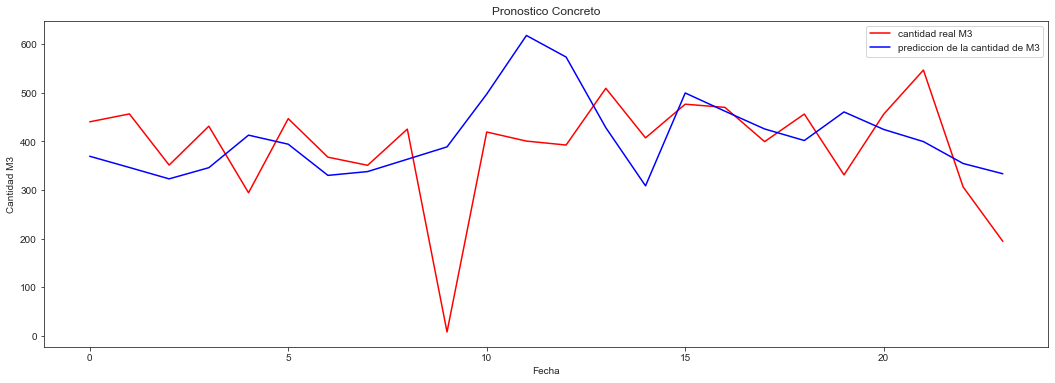

In [339]:
plt.figure(figsize=(18,6))
plt.plot(test_set[: , 0], color = 'red', label = 'cantidad real M3')
plt.plot(prediction[:, 0:1], color = 'blue', label = 'prediccion de la cantidad de M3')
plt.title('Pronostico Concreto')
plt.xlabel('Fecha')
plt.ylabel('Cantidad M3')
plt.legend()
plt.show()

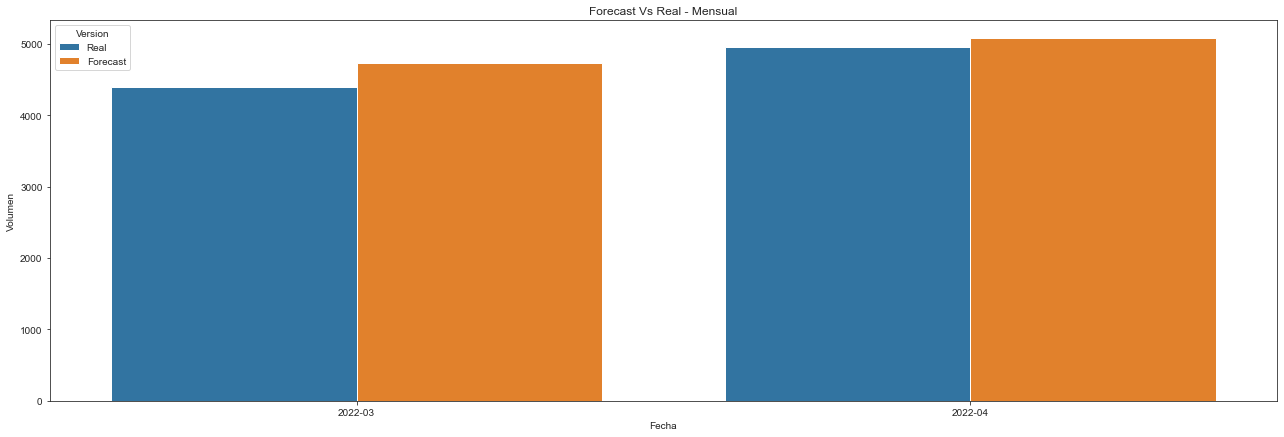

,year-month,Real,Forecast,Desviacion
0,2022-03,4394.35,4729.443135,0.076255
1,2022-04,4948.50,5074.777156,0.025518


In [340]:
#Unir prediccion y real en dataframe para comparar
df_real_prediccion = pd.DataFrame({'Real':test_set[: , 0], 'Forecast':prediction[:, 0]})
df_real_prediccion = pd.concat([dataset_test[['FechaEntrega']].reset_index(), df_real_prediccion], axis = 1)
df_real_prediccion['year-month'] = df_real_prediccion['FechaEntrega'].dt.to_period('M')
#Agrupar a nivel mensual y calcular desviacion
df_real_prediccion = df_real_prediccion.groupby(['year-month']).agg({'Real':sum, 'Forecast':sum}).reset_index()
df_real_prediccion['Desviacion'] = ((df_real_prediccion['Real'] - df_real_prediccion['Forecast']).abs())/df_real_prediccion['Real'].fillna(0) 

#se utiliza el metodo melt para realizar grafica comparativa
df_real_prediccion_melt = pd.melt(df_real_prediccion, id_vars = ['year-month'], value_vars=['Real', 'Forecast'], var_name='Version', value_name='Volumen')

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(22,7)
rotation = 45
sns.barplot(x=df_real_prediccion_melt['year-month'], y = df_real_prediccion_melt['Volumen'], hue=df_real_prediccion_melt['Version'])
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.title('Forecast Vs Real - Mensual')
plt.show()

df_real_prediccion

In [1]:
#Importar librerias
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import modulo_conn_sql as mcq

from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

# Construcción del dataset

La idea es construir un dataset para hacer predicciones <b> mensuales por ciudad </b> aplicando modelos de regresion lineal

In [2]:
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

def obras_mes_actual(dataset, fecha_ref):
    #filtro los registros de este mes, teniendo en cuenta la fecha relativa actual
    dataset = dataset[dataset['year_month'] ==  (fecha_ref - MonthBegin(1)).to_period('M') ]
    dataset = dataset.groupby(['year_month', 'Cluster', 'Ciudad']).agg({'Obra':pd.Series.nunique}).reset_index()
    return dataset

def obras_mes_trimestre(dataset, fecha_ref):
    #filtro los registros de este mes, teniendo en cuenta la fecha relativa actual
    dataset = dataset[(dataset['FechaEntrega'] >= fecha_ref - MonthBegin(4)) & (dataset['FechaEntrega'] < fecha_ref - MonthBegin(1))]
    dataset = dataset.groupby(['year_month','Cluster', 'Ciudad']).agg({'Obra':pd.Series.nunique}).reset_index()
    dataset = dataset.groupby(['Cluster', 'Ciudad']).agg({'Obra':'mean'}).reset_index()
    return dataset

def edad_vol_mes_trimestre(dataset, fecha_ref):
    #filtro los registros de este mes, teniendo en cuenta la fecha relativa actual
    dataset = dataset[(dataset['year_month'] >= fecha_ref - MonthBegin(2)) & (dataset['year_month'] < fecha_ref )]
    #dataset = dataset.groupby(['year_month','Ciudad']).agg({'Edad':'median'}).reset_index()
    dataset = dataset.groupby(['Ciudad']).agg({'Edad':'mean'}).reset_index()
    dataset['year_month'] = fecha_ref
    return dataset

In [54]:
#Variables 
pais='Colombia'
years = [2019, 2020, 2021,2022]

#Consulta al SQL
for i,var in enumerate(years):
    if i == 0:
        df = querySQL( "{CALL SCAC_AP10_dataset_servicios_years (?,?)}" , (pais, var) )
        df = df.fillna(value=np.nan)
        df['year_month'] = df.FechaEntrega.dt.to_period('M')
    else:
        temp = querySQL( "{CALL SCAC_AP10_dataset_servicios_years (?,?)}" , (pais, var) )
        temp = temp.fillna(value=np.nan)
        temp['year_month'] = temp.FechaEntrega.dt.to_period('M')
        
        df = pd.concat([df, temp ])
        

In [56]:
#CONSULTA SQL - edad del volumen
edad = querySQL( "{CALL SCAC_AP13_EdadVolumen (?,?,?)}" , (pais, '2019-01-01', '2022-09-01') )
edad['Fecha'] = pd.to_datetime(edad['Fecha'])
edad['Obra'] = edad['Obra'].astype(str)
edad['year_month'] = edad.Fecha.dt.to_period('M')
edad['Edad'] = pd.to_datetime(edad['Fecha']) - pd.to_datetime(edad['PrimerConsumo'])
edad['Edad'] = edad['Edad'] / np.timedelta64(1,'D')

OperationalError: ('08S01', '[08S01] [Microsoft][ODBC Driver 17 for SQL Server]TCP Provider: A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond.\r\n (10060) (SQLExecDirectW); [08S01] [Microsoft][ODBC Driver 17 for SQL Server]Communication link failure (10060)')

In [5]:
#CONSULTA SQL - ubicacion de las plantas
coordenadas_planta = querySQL( "select * from Coordenadas_Plantas_Concreto", ())

In [6]:
#Se agrega informacion adicional

coordenadas_planta = coordenadas_planta[['COD_SAP_PLANTA', 'LATITUD_PLANTA', 'LONGITUD_PLANTA']]

df = pd.merge(df, coordenadas_planta, left_on='Centro', right_on='COD_SAP_PLANTA', how='left')
df = df.drop(['COD_SAP_PLANTA'], axis=1)

#Ajuste de formatos
df['year_month'] = df['year_month'].astype(str)
df = df.sort_values(by=['year_month'])
df['year_month'] =  pd.to_datetime(df['year_month'])
df['year_month'] =  df['year_month'].dt.to_period('M')

df['LATITUD_PLANTA'] =  df['LATITUD_PLANTA'].astype(float)
df['LONGITUD_PLANTA'] =  df['LONGITUD_PLANTA'].astype(float)

#se excluyen plantas dedicadas a obras puntuales y traiding
df = df[df['TipoPlanta'] == 'Central']

In [7]:
df.head().T

,120745,110481,110482,110483,110484
Pedido,8010778903,8010726078-S,8010716558,8010716558,8010716558
servicio,L003,L001,L001,L002,L003
Entrega,189295222,188430857,188430742,188431292,188433347
Estatus,Normal,Normal,Normal,Normal,Normal
EstatusPedido,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera
Cluster,CLUSTER SANTANDER,CLUSTER CENTRO,CLUSTER COSTA,CLUSTER COSTA,CLUSTER COSTA
Planta,CO-PLANTA FLORIDA,CO-PLANTA SIBERIA,CO-PLANTA BARRANQUILLA,CO-PLANTA BARRANQUILLA,CO-PLANTA BARRANQUILLA
TipoPlanta,Central,Central,Central,Central,Central
Ciudad,Bucaramanga,Bogotá,Barranquilla,Barranquilla,Barranquilla
Centro,F066,F058,F014,F014,F014


In [8]:
#Volumen mensual
vol = df.groupby(['year_month', 'Cluster', 'Ciudad']).agg({'VolPartida': sum}).reset_index()
vol['year_month'] = vol['year_month'].astype(str)
vol

,year_month,Cluster,Ciudad,VolPartida
0,2021-01,CLUSTER ANTIOQUIA,Medellín,6485.25
1,2021-01,CLUSTER ANTIOQUIA,Rionegro,1919.00
2,2021-01,CLUSTER CENTRO,Bogotá,53210.00
3,2021-01,CLUSTER COSTA,Barranquilla,3711.25
4,2021-01,CLUSTER COSTA,Cartagena,3612.50
...,...,...,...,...
193,2022-02,CLUSTER SANTANDER,Cúcuta,1147.75
194,2022-02,CLUSTER SURORIENTE,Fusagasuga,371.75
195,2022-02,CLUSTER SURORIENTE,Ibagué,2879.00
196,2022-02,CLUSTER SURORIENTE,Neiva,1595.75


In [16]:
#Ubicacion promedio de las plantas

ubicacion_plantas = df.groupby(['year_month', 'Cluster', 'Ciudad']).agg({'LATITUD_PLANTA': 'median', 'LONGITUD_PLANTA': 'median'}).reset_index()
ubicacion_plantas['year_month'] = ubicacion_plantas['year_month'].astype(str)
ubicacion_plantas

,year_month,Cluster,Ciudad,LATITUD_PLANTA,LONGITUD_PLANTA
0,2021-01,CLUSTER ANTIOQUIA,Medellín,6.157566,-75.635033
1,2021-01,CLUSTER ANTIOQUIA,Rionegro,6.139693,-75.392174
2,2021-01,CLUSTER CENTRO,Bogotá,4.733480,-74.110851
3,2021-01,CLUSTER COSTA,Barranquilla,11.000543,-74.780649
4,2021-01,CLUSTER COSTA,Cartagena,10.356020,-75.496130
...,...,...,...,...,...
193,2022-02,CLUSTER SANTANDER,Cúcuta,7.925232,-72.477893
194,2022-02,CLUSTER SURORIENTE,Fusagasuga,4.345000,-74.380900
195,2022-02,CLUSTER SURORIENTE,Ibagué,4.428680,-75.198944
196,2022-02,CLUSTER SURORIENTE,Neiva,2.860576,-75.273745


In [10]:
#Distancia media en km desde las plantas hasta las obras
distancia = df.groupby(['year_month', 'Cluster', 'Ciudad']).agg({'DistanciaPlantaObraKm': 'median' }).reset_index()
distancia['year_month'] = distancia['year_month'].astype(str)
distancia

,year_month,Cluster,Ciudad,DistanciaPlantaObraKm
0,2021-01,CLUSTER ANTIOQUIA,Medellín,8.537535
1,2021-01,CLUSTER ANTIOQUIA,Rionegro,17.376328
2,2021-01,CLUSTER CENTRO,Bogotá,9.160531
3,2021-01,CLUSTER COSTA,Barranquilla,13.786619
4,2021-01,CLUSTER COSTA,Cartagena,8.787131
...,...,...,...,...
193,2022-02,CLUSTER SANTANDER,Cúcuta,9.756442
194,2022-02,CLUSTER SURORIENTE,Fusagasuga,5.829079
195,2022-02,CLUSTER SURORIENTE,Ibagué,4.277958
196,2022-02,CLUSTER SURORIENTE,Neiva,15.622351


In [11]:
#Centros de despacho activos
plantas_activas = df.groupby(['year_month', 'Cluster', 'Ciudad']).agg({'Centro':  pd.Series.nunique }).reset_index()
plantas_activas['year_month'] = plantas_activas['year_month'].astype(str)
plantas_activas

,year_month,Cluster,Ciudad,Centro
0,2021-01,CLUSTER ANTIOQUIA,Medellín,2
1,2021-01,CLUSTER ANTIOQUIA,Rionegro,1
2,2021-01,CLUSTER CENTRO,Bogotá,11
3,2021-01,CLUSTER COSTA,Barranquilla,1
4,2021-01,CLUSTER COSTA,Cartagena,1
...,...,...,...,...
193,2022-02,CLUSTER SANTANDER,Cúcuta,1
194,2022-02,CLUSTER SURORIENTE,Fusagasuga,1
195,2022-02,CLUSTER SURORIENTE,Ibagué,1
196,2022-02,CLUSTER SURORIENTE,Neiva,1


In [12]:
#Cumplimiento
cumpto = df.groupby(['year_month', 'Cluster', 'Ciudad'])['Cumplimiento'].agg(['sum','count']).reset_index()
cumpto['cumpto_mes'] = cumpto['sum']/cumpto['count']
cumpto['year_month'] = cumpto['year_month'].astype(str)
cumpto = cumpto.drop(['sum', 'count'], axis=1)
cumpto

,year_month,Cluster,Ciudad,cumpto_mes
0,2021-01,CLUSTER ANTIOQUIA,Medellín,0.855236
1,2021-01,CLUSTER ANTIOQUIA,Rionegro,0.968966
2,2021-01,CLUSTER CENTRO,Bogotá,0.932401
3,2021-01,CLUSTER COSTA,Barranquilla,0.976449
4,2021-01,CLUSTER COSTA,Cartagena,0.943327
...,...,...,...,...
193,2022-02,CLUSTER SANTANDER,Cúcuta,0.919540
194,2022-02,CLUSTER SURORIENTE,Fusagasuga,0.672727
195,2022-02,CLUSTER SURORIENTE,Ibagué,0.628235
196,2022-02,CLUSTER SURORIENTE,Neiva,0.870690


In [13]:
# analisis de cual es la media de la edad del volumen y cuanto es el volumen nuevo
analisis_edad = edad[~edad['Obra'].str.contains('F')].groupby(['year_month','Obra']).agg({'Edad':'max', 'Vol':'sum'}).reset_index()
analisis_edad['volumen_nuevo'] = analisis_edad['Vol'].where(analisis_edad['Edad'] <= 30 , 0)
pivot_temp = df.groupby(['year_month','Cluster', 'Ciudad', 'Obra']).agg({'VolPartida': sum}).reset_index()
pivot_temp = pd.merge( pivot_temp, analisis_edad, how='left', on=(['year_month', 'Obra']) ) 
pivot_temp = pivot_temp.replace(0, np.nan)
analisis_edad = pivot_temp.groupby(['year_month', 'Cluster','Ciudad']).agg({'Edad':'median', 'volumen_nuevo':'sum'}).reset_index()
analisis_edad['year_month'] = analisis_edad['year_month'].astype(str)
analisis_edad

,year_month,Cluster,Ciudad,Edad,volumen_nuevo
0,2021-01,CLUSTER ANTIOQUIA,Medellín,128.0,1237.00
1,2021-01,CLUSTER ANTIOQUIA,Rionegro,67.5,914.50
2,2021-01,CLUSTER CENTRO,Bogotá,234.0,3298.75
3,2021-01,CLUSTER COSTA,Barranquilla,149.0,343.75
4,2021-01,CLUSTER COSTA,Cartagena,293.0,97.00
...,...,...,...,...,...
193,2022-02,CLUSTER SANTANDER,Cúcuta,125.0,0.00
194,2022-02,CLUSTER SURORIENTE,Fusagasuga,296.5,74.00
195,2022-02,CLUSTER SURORIENTE,Ibagué,209.0,91.00
196,2022-02,CLUSTER SURORIENTE,Neiva,172.5,38.75


In [14]:
# Numero de obras mensuales y su relacion con la media trimestral
indicador_numero_obras = pd.DataFrame()
for i in range(len(df['year_month'].unique()) - 1):
    obras_actuales = obras_mes_actual(df, datetime.date.today() - MonthBegin(i))
    obras_trimestre = obras_mes_trimestre(df, datetime.date.today() - MonthBegin(i))
    temp = pd.merge(obras_actuales, obras_trimestre, how='left', on=['Cluster', 'Ciudad'])
    temp['indicador_numero_obras'] = temp['Obra_x'] / temp['Obra_y']

    if i == 0:
        indicador_numero_obras = temp
    else:
        indicador_numero_obras = pd.concat([indicador_numero_obras, temp])
        
indicador_numero_obras['year_month'] = indicador_numero_obras['year_month'].astype(str)
indicador_numero_obras.rename(columns = {'Obra_x':'obras_mes', 'Obra_y':'obras_trimestre'}, inplace = True)
indicador_numero_obras

,year_month,Cluster,Ciudad,obras_mes,obras_trimestre,indicador_numero_obras
0,2022-02,CLUSTER ANTIOQUIA,Medellín,59,95.333333,0.618881
1,2022-02,CLUSTER ANTIOQUIA,Rionegro,39,66.666667,0.585000
2,2022-02,CLUSTER CENTRO,Bogotá,218,306.000000,0.712418
3,2022-02,CLUSTER COSTA,Barranquilla,37,48.333333,0.765517
4,2022-02,CLUSTER COSTA,Cartagena,18,22.000000,0.818182
...,...,...,...,...,...,...
9,2021-02,CLUSTER SANTANDER,Bucaramanga,42,36.000000,1.166667
10,2021-02,CLUSTER SANTANDER,Cúcuta,12,12.000000,1.000000
11,2021-02,CLUSTER SURORIENTE,Ibagué,25,22.000000,1.136364
12,2021-02,CLUSTER SURORIENTE,Neiva,16,14.000000,1.142857


In [32]:
#Union de los datasets anteriores
df_kpis = pd.merge(vol, indicador_numero_obras, how='left', on=['year_month', 'Cluster', 'Ciudad'] )
df_kpis = pd.merge(df_kpis, analisis_edad, how = 'left', on=['year_month','Cluster', 'Ciudad'] )
df_kpis = pd.merge(df_kpis, distancia, how = 'left', on=['year_month','Cluster', 'Ciudad'] )
df_kpis = pd.merge(df_kpis, plantas_activas, how = 'left', on=['year_month','Cluster', 'Ciudad'] )
df_kpis = pd.merge(df_kpis, cumpto, how = 'left', on=['year_month','Cluster', 'Ciudad'] )
df_kpis = pd.merge(df_kpis, ubicacion_plantas, how = 'left', on=['year_month','Cluster', 'Ciudad'] )

reg = df_kpis.drop(['year_month', 'Cluster', 'Ciudad', 'obras_mes', 'obras_trimestre'],axis=1)


df_kpis.tail(30)

,year_month,Cluster,Ciudad,VolPartida,obras_mes,obras_trimestre,indicador_numero_obras,Edad,volumen_nuevo,DistanciaPlantaObraKm,Centro,cumpto_mes,LATITUD_PLANTA,LONGITUD_PLANTA
168,2022-01,CLUSTER ANTIOQUIA,Medellín,6581.75,72.0,113.000000,0.637168,113.0,560.75,8.794707,2,0.886458,6.157566,-75.635033
169,2022-01,CLUSTER ANTIOQUIA,Rionegro,4073.00,67.0,66.666667,1.005000,87.0,1133.00,9.618225,1,0.866232,6.139693,-75.392174
170,2022-01,CLUSTER CENTRO,Bogotá,50670.50,273.0,330.666667,0.825605,224.0,2536.50,8.867720,11,0.898389,4.686583,-74.110851
171,2022-01,CLUSTER COSTA,Barranquilla,7496.75,54.0,42.666667,1.265625,130.0,2293.25,13.865468,1,0.806133,11.000543,-74.780649
172,2022-01,CLUSTER COSTA,Cartagena,4769.25,25.0,21.000000,1.190476,140.0,1127.25,8.785581,1,0.808199,10.356020,-75.496130
173,2022-01,CLUSTER COSTA,Santa Marta,1683.25,14.0,18.333333,0.763636,187.0,78.50,20.798748,1,0.941176,11.018958,-74.211236
174,2022-01,CLUSTER OCCIDENTE,Cali,8811.25,74.0,88.666667,0.834586,162.0,1083.50,12.098051,2,0.892668,3.302593,-76.478444
175,2022-01,CLUSTER OCCIDENTE,Pereira,3170.50,19.0,24.666667,0.770270,335.0,95.00,10.889725,1,0.947846,4.821802,-75.689166
176,2022-01,CLUSTER OCCIDENTE,Tuluá,1179.75,14.0,18.333333,0.763636,99.0,364.50,35.397186,1,0.952096,4.088678,-76.162636
177,2022-01,CLUSTER SANTANDER,Bucaramanga,6300.00,28.0,40.333333,0.694215,124.0,1721.00,9.635892,1,0.895433,7.060505,-73.092192


<AxesSubplot:>

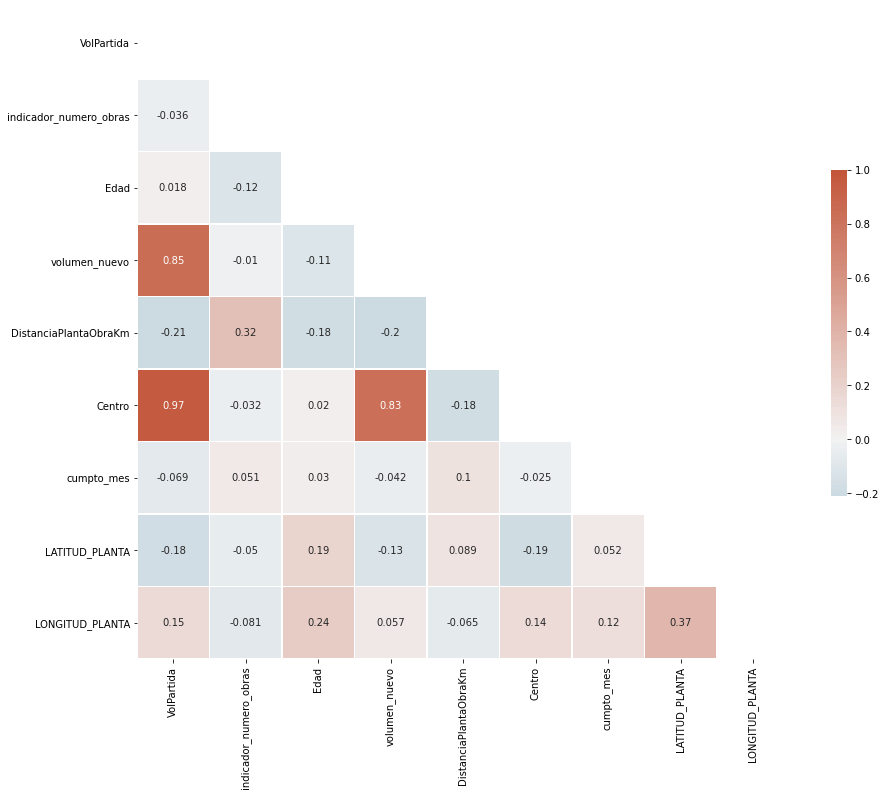

In [33]:
# Análisis de correlaciones
df_correlation = reg.corr()

mask = np.triu(np.ones_like(df_correlation, dtype=bool))
f, ax = plt.subplots(figsize=(15, 12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_correlation, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

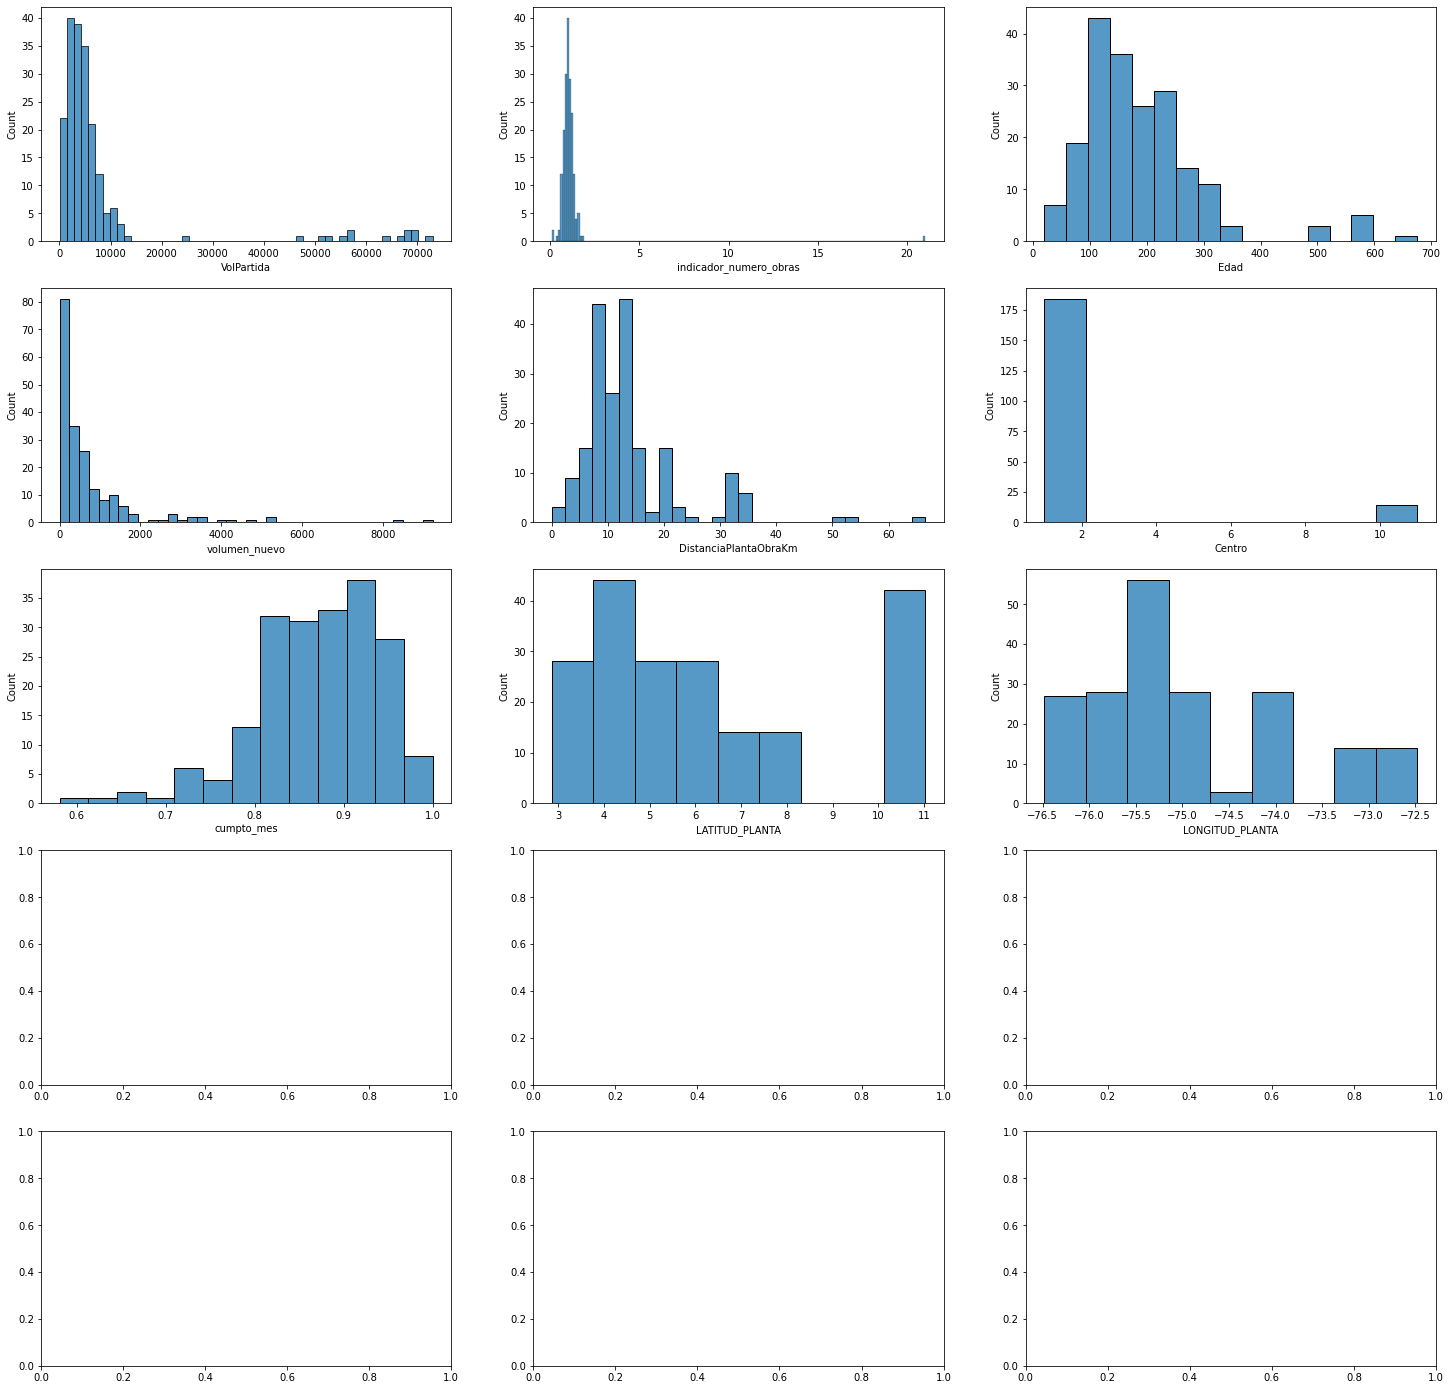

In [34]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (25, 25))
for name, ax in zip(reg.columns, axes.flatten()):
    sns.histplot(x = name, data = reg, ax = ax)

In [20]:
#reg = pd.get_dummies(reg, drop_first = True)
#reg

,VolPartida,indicador_numero_obras,Edad,volumen_nuevo,DistanciaPlantaObraKm,Centro,cumpto_mes,LATITUD_PLANTA,LONGITUD_PLANTA,Ciudad_Bogotá,...,Ciudad_Cúcuta,Ciudad_Fusagasuga,Ciudad_Ibagué,Ciudad_Medellín,Ciudad_Neiva,Ciudad_Pereira,Ciudad_Ricaurte,Ciudad_Rionegro,Ciudad_Santa Marta,Ciudad_Tuluá
0,6485.25,NaN,128.0,1237.00,8.537535,2,0.855236,6.157566,-75.635033,0,...,0,0,0,1,0,0,0,0,0,0
1,1919.00,NaN,67.5,914.50,17.376328,1,0.968966,6.139693,-75.392174,0,...,0,0,0,0,0,0,0,1,0,0
2,53210.00,NaN,234.0,3298.75,9.160531,11,0.932401,4.733480,-74.110851,1,...,0,0,0,0,0,0,0,0,0,0
3,3711.25,NaN,149.0,343.75,13.786619,1,0.976449,11.000543,-74.780649,0,...,0,0,0,0,0,0,0,0,0,0
4,3612.50,NaN,293.0,97.00,8.787131,1,0.943327,10.356020,-75.496130,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,1147.75,0.550000,125.0,0.00,9.756442,1,0.919540,7.925232,-72.477893,0,...,1,0,0,0,0,0,0,0,0,0
194,371.75,1.090909,296.5,74.00,5.829079,1,0.672727,4.345000,-74.380900,0,...,0,1,0,0,0,0,0,0,0,0
195,2879.00,0.721519,209.0,91.00,4.277958,1,0.628235,4.428680,-75.198944,0,...,0,0,1,0,0,0,0,0,0,0
196,1595.75,0.750000,172.5,38.75,15.622351,1,0.870690,2.860576,-75.273745,0,...,0,0,0,0,1,0,0,0,0,0


In [35]:
reg =reg[reg['indicador_numero_obras'].notnull()]
reg = reg[reg['Edad'].notnull()]

In [36]:
reg

,VolPartida,indicador_numero_obras,Edad,volumen_nuevo,DistanciaPlantaObraKm,Centro,cumpto_mes,LATITUD_PLANTA,LONGITUD_PLANTA
13,10357.00,1.253012,112.0,1776.00,8.296714,2,0.802063,6.157566,-75.635033
14,4323.00,1.458333,57.0,2745.00,13.527067,1,0.807813,6.139693,-75.392174
15,63721.65,1.131148,246.0,9223.50,8.468585,11,0.944029,4.733480,-74.110851
16,5704.25,1.387097,164.0,684.50,13.717493,1,0.943350,11.000543,-74.780649
17,4093.50,0.823529,297.5,19.00,8.787131,1,0.835000,10.356020,-75.496130
...,...,...,...,...,...,...,...,...,...
193,1147.75,0.550000,125.0,0.00,9.756442,1,0.919540,7.925232,-72.477893
194,371.75,1.090909,296.5,74.00,5.829079,1,0.672727,4.345000,-74.380900
195,2879.00,0.721519,209.0,91.00,4.277958,1,0.628235,4.428680,-75.198944
196,1595.75,0.750000,172.5,38.75,15.622351,1,0.870690,2.860576,-75.273745


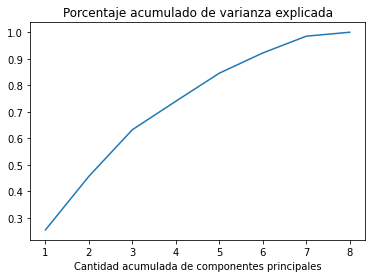

In [37]:
#definicion de X y y (train y test)
y = reg["VolPartida"].values
X = reg.drop(["VolPartida"], axis = 1).values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1111)

#escalamiento de datos
scaler = StandardScaler()
scaler.fit(x_train)
XEscaladoTrain=scaler.transform(x_train)

#Definicion de matriz A
p=len(XEscaladoTrain[1,])
pca = PCA(n_components=p).fit(XEscaladoTrain)
A=pca.components_

#analisis de varianza para seleccion de componentes
varianzaExplicada=pca.explained_variance_
porcentajeVarianzaExplicada=pca.explained_variance_ratio_

plt.plot(range(1,p+1),np.cumsum(porcentajeVarianzaExplicada))
plt.xlabel('Cantidad acumulada de componentes principales')
plt.title('Porcentaje acumulado de varianza explicada')
plt.show()

In [38]:
range(1,p+1),np.cumsum(porcentajeVarianzaExplicada)

(range(1, 9),
 array([0.25432192, 0.45668072, 0.63233257, 0.73984368, 0.84568425,
        0.92190723, 0.98519354, 1.        ]))

In [41]:
nComponentesElegidas=8

ZTotalTrain=np.matmul(XEscaladoTrain,A)
ZTrain = ZTotalTrain[:,range(nComponentesElegidas)]

#creacion del regresor utilizando los componentes seleccionados
regPCA = LinearRegression()
regPCA.fit(ZTrain, y_train)

#aplicacion del regresor en el conjunto de test
XEscaladoTest=scaler.transform(x_test)

ZTotalTest=np.matmul(XEscaladoTest,A)
ZTest = ZTotalTest[:,range(nComponentesElegidas)]

prediccionPCA=regPCA.predict(ZTest)
MSEPCA=np.average(np.square(prediccionPCA-y_test))
print('MSE regresión por componentes principales:')
print(MSEPCA**0.5)

MSE regresión por componentes principales:
2595.551041880708


In [42]:
prediccionPCA

array([ 2137.12110903,  5163.47522873,  3281.45384452,  3267.39506638,
        8654.05408937,  3005.89138733,  2821.67540133,  4408.39138546,
        8484.64092088,  3438.92652182, 57601.28994539, 10273.84718972,
        3838.87633983, 59801.09601148,  3664.5111787 ,  3306.81379607,
        4285.23023178,  8790.43635384,  2496.5189492 ,  2139.37960131,
        4453.78715912,  4438.07446123,  3560.58316136,  4352.59431977,
        4189.46226411,  3633.51008372,  3129.8427298 ,  3822.7523599 ,
        4151.8741191 ,  4609.3651888 ,  1972.10339228,  4503.54168493,
        1416.94965437,  5686.69489084,  9745.22617988, 10759.81514609,
        3860.3645484 ,  8697.17736782,  9633.90269286,  3981.44403552,
       58560.8538472 ,  1241.81822286,  2976.04177187,  9713.62191665,
        8859.92944802,  3735.79557286])

In [43]:
y_test

array([1.721000e+03, 6.000000e+03, 5.704250e+03, 1.294500e+03,
       6.757750e+03, 3.179000e+03, 3.632000e+03, 6.890700e+03,
       1.177925e+04, 4.273750e+03, 5.067050e+04, 8.439200e+03,
       4.205500e+03, 6.961365e+04, 4.215000e+03, 4.093500e+03,
       3.812750e+03, 1.052025e+04, 1.673500e+03, 2.632000e+03,
       1.680000e+03, 4.601000e+03, 5.952250e+03, 2.641500e+03,
       6.837000e+03, 3.238750e+03, 3.141000e+03, 4.733750e+03,
       1.205250e+03, 4.073000e+03, 2.100000e+01, 6.098000e+03,
       8.160000e+02, 3.899000e+03, 7.089950e+03, 8.043750e+03,
       3.867250e+03, 6.581750e+03, 8.037000e+03, 5.183750e+03,
       5.504225e+04, 1.109500e+03, 2.692500e+03, 6.808450e+03,
       2.978750e+03, 2.080250e+03])

In [44]:
#PLS

pls = PLSRegression(n_components=nComponentesElegidas)
pls.fit(x_train, y_train)
prediccionPLS=pls.predict(x_test)
prediccionPLS=np.hstack(prediccionPLS)
MSEPLS=np.average(np.square(prediccionPLS-y_test))
print('MSE regresión por partial least squares:')
print(MSEPLS**0.5)

MSE regresión por partial least squares:
2595.5510418807103


In [47]:
#Modelo con penalizacion tipo Ridge
n_alphas = 200
alphasCalibrar = np.logspace(-10, 2, n_alphas)
modeloRidge = RidgeCV(alphas=alphasCalibrar,store_cv_values=True).fit(x_train, y_train)

prediccionRidge=modeloRidge.predict(x_test)
MSERidge=np.average(np.square(prediccionRidge-y_test))
print('MSE regresión con penalización tipo Ridge:')
print(MSERidge**0.5)

MSE regresión con penalización tipo Ridge:
2790.6176039275883


In [52]:
#Modelo con penalizacion ElasticNet

n_alphas = 200
alphasCalibrar = np.logspace(-10, 2, n_alphas)
modeloElastic = ElasticNetCV(alphas=alphasCalibrar,cv=5, random_state=0).fit(x_train,y_train)

prediccionElastic=modeloElastic.predict(x_test)
MSEElastic=np.average(np.square(prediccionElastic-y_test))
print('MSE regresión con penalización tipo Elastic Net:')
print(MSEElastic**0.5)

C:\Users\JSDELGADOC\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105275828.12424397, tolerance: 2690401.363281179
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JSDELGADOC\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11437281.500383139, tolerance: 2690401.363281179
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JSDELGADOC\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2723516.267356634, tolerance: 2690401.363281179
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JSDELGADOC\Anaconda3\lib\site-packages\sklearn\linear_model\_coordin

MSE regresión con penalización tipo Elastic Net:
2727.887063570293


C:\Users\JSDELGADOC\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 503088944.2158801, tolerance: 2053089.9857949007
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JSDELGADOC\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 565678166.1764765, tolerance: 2053089.9857949007
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JSDELGADOC\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250708471.82104635, tolerance: 2053089.9857949007
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\JSDELGADOC\Anaconda3\lib\site-packages\sklearn\linear_model\_coord

In [46]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

In [24]:
import modulo_conn_sql as mcq
import numpy as np
import seaborn as sns
import pandas as pd 
import datetime 
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin
import random


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression




In [ ]:
#PRINCIPAL

############################################# PARAMETROS #############################################
pais = 'Colombia'
inicioHistoria = datetime.datetime(2019, 1, 1) #'2013-05-01'
finHistoria = datetime.datetime(2022, 2 , 7)


######################################### FIN PARAMETROS #############################################

#Consulta de datos en la base SQL
despachosSQL = querySQL(  "{CALL SCAC_AP8_BaseForecast (?,?,?)}", (pais, inicioHistoria.strftime("%Y-%m-%d"), finHistoria.strftime("%Y-%m-%d") ) )
coordenadas_planta = querySQL( "select * from Coordenadas_Plantas_Concreto", ())


In [122]:
df_despacho = despachosSQL[['Planta','FechaEntrega','totalEntregado', 'Año', 'Mes', 'Semana_Relativa', 'DiaSemana', 'TipoPlanta']]

coordenadas_planta = coordenadas_planta[['COD_SAP_PLANTA', 'LATITUD_PLANTA', 'LONGITUD_PLANTA']]

df = pd.merge(df_despacho, coordenadas_planta, left_on='Planta', right_on='COD_SAP_PLANTA', how='left')
df = df.drop(['COD_SAP_PLANTA', 'Planta', 'FechaEntrega'], axis=1)
#df = df.drop(['COD_SAP_PLANTA',  'FechaEntrega'], axis=1)

#arreglo de formatos
df['totalEntregado'] = df['totalEntregado'].astype(float)
df['Año'] = df['Año'].astype(float)
df['Mes'] = df['Mes'].astype(float)
df['Semana_Relativa'] = df['Semana_Relativa'].astype(float)
df['DiaSemana'] = df['DiaSemana'].astype(float)
df['LATITUD_PLANTA'] = df['LATITUD_PLANTA'].astype(float)
df['LONGITUD_PLANTA'] = df['LONGITUD_PLANTA'].astype(float)
df['logvol'] = np.log(df['totalEntregado'])

df = pd.get_dummies(df, drop_first = True)

df

,totalEntregado,Año,Mes,Semana_Relativa,DiaSemana,LATITUD_PLANTA,LONGITUD_PLANTA,logvol,TipoPlanta_Central,TipoPlanta_Trading
0,311.50,2019.0,12.0,3.0,7.0,11.000543,-74.780649,5.741399,1,0
1,275.25,2019.0,2.0,2.0,6.0,4.594528,-74.180576,5.617680,1,0
2,85.50,2019.0,9.0,2.0,6.0,11.018958,-74.211236,4.448516,1,0
3,324.00,2019.0,10.0,1.0,4.0,6.322034,-75.551195,5.780744,1,0
4,318.25,2022.0,1.0,3.0,3.0,4.750689,-74.022736,5.762837,1,0
...,...,...,...,...,...,...,...,...,...,...
23904,24.00,2019.0,5.0,5.0,1.0,7.060505,-73.092192,3.178054,1,0
23905,315.50,2021.0,2.0,2.0,6.0,4.750689,-74.022736,5.754159,1,0
23906,72.00,2021.0,3.0,4.0,6.0,4.088678,-76.162636,4.276666,1,0
23907,508.25,2021.0,8.0,1.0,5.0,4.816720,-74.037085,6.230973,1,0


<AxesSubplot:>

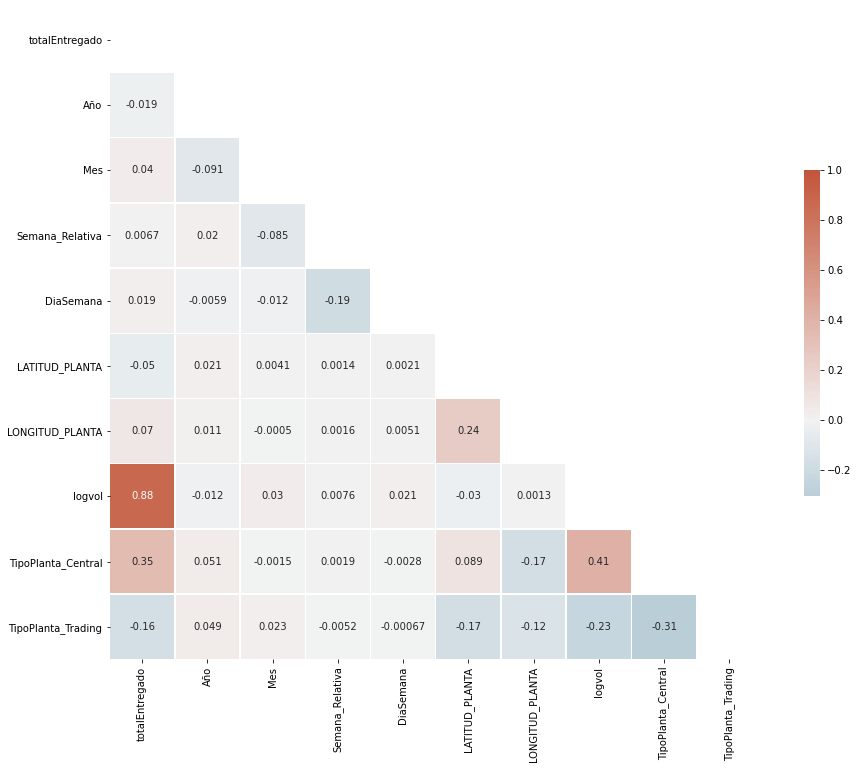

In [123]:
# Análisis de correlaciones
df_correlation = df.corr()

mask = np.triu(np.ones_like(df_correlation, dtype=bool))
f, ax = plt.subplots(figsize=(15, 12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_correlation, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

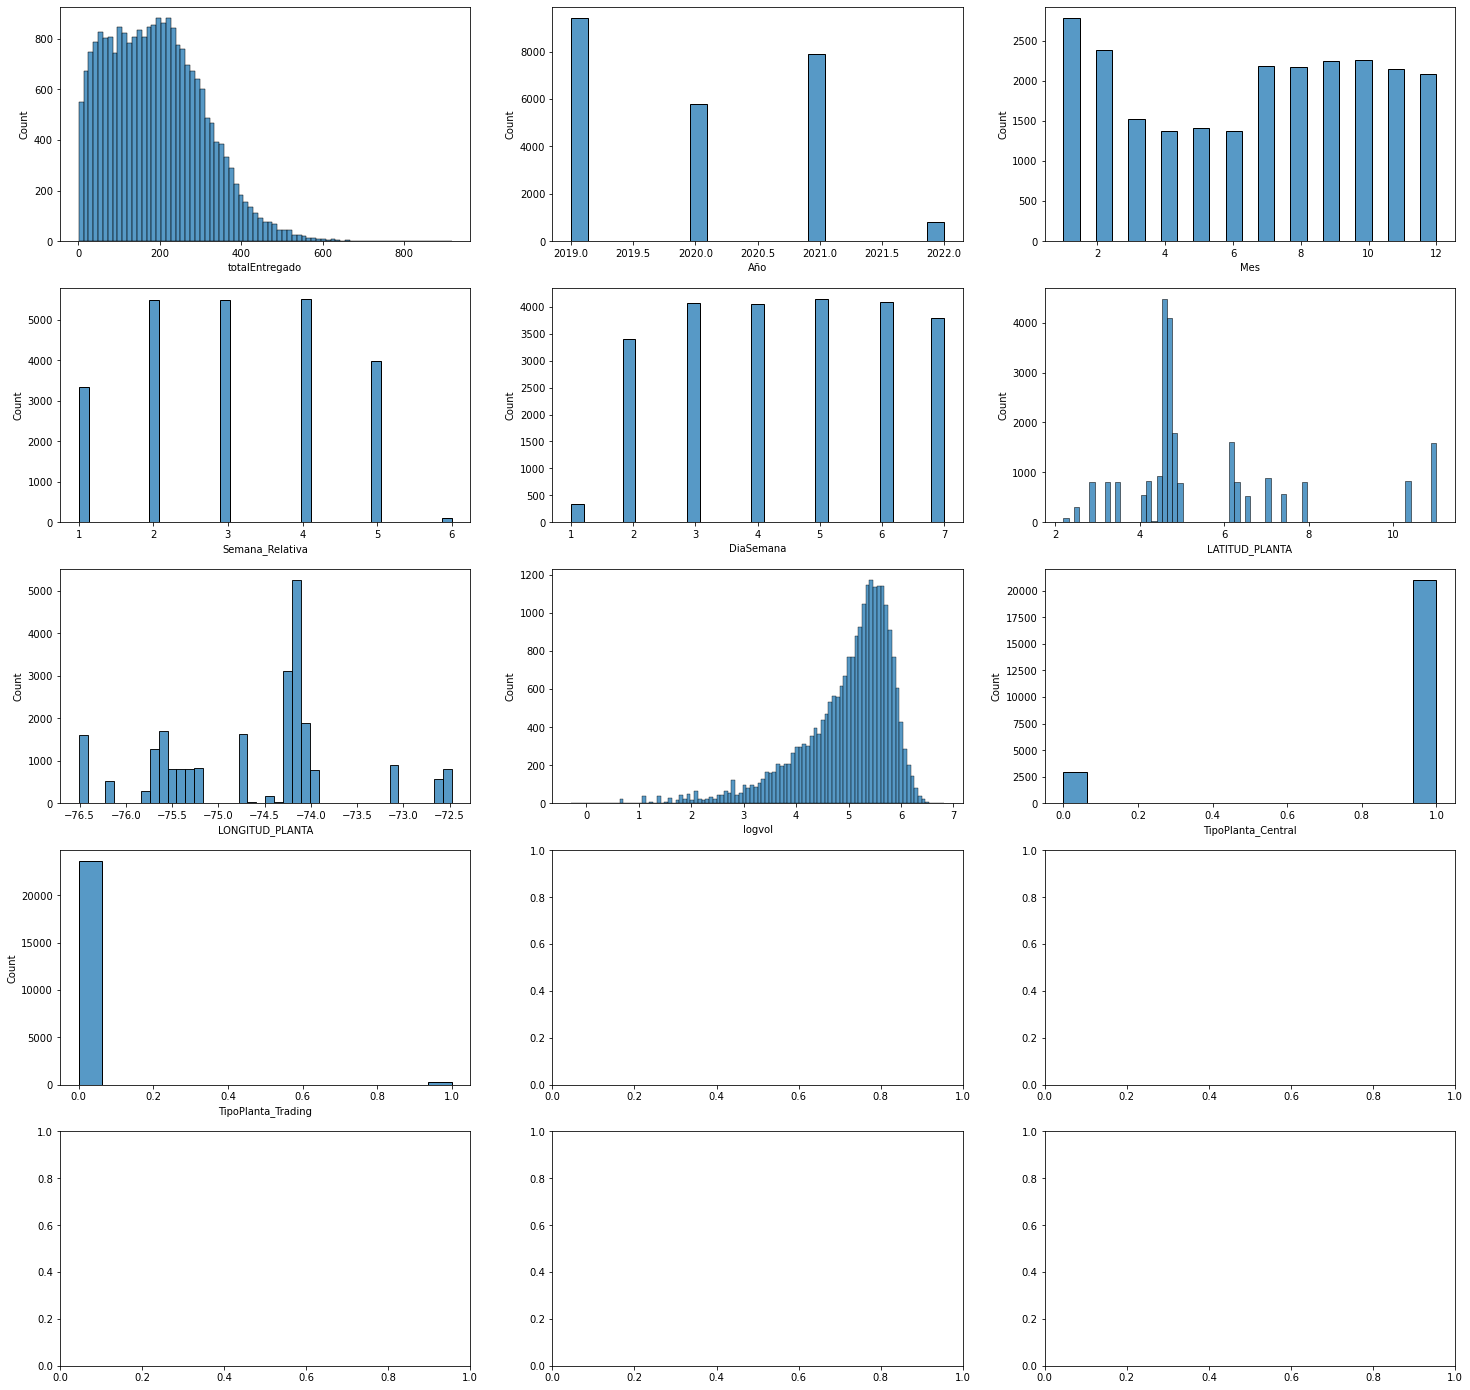

In [124]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (25, 25))

for name, ax in zip(df.columns, axes.flatten()):
    sns.histplot(x = name, data = df, ax = ax)

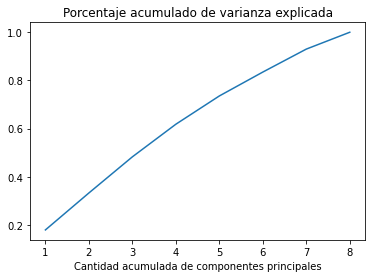

In [126]:
#definicion de X y y (train y test)
y = df["logvol"].values
X = df.drop(["logvol","totalEntregado"], axis = 1).values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1111)

#escalamiento de datos
scaler = StandardScaler()
scaler.fit(x_train)
XEscaladoTrain=scaler.transform(x_train)

#Definicion de matriz A
p=len(XEscaladoTrain[1,])
pca = PCA(n_components=p).fit(XEscaladoTrain)
A=pca.components_

#analisis de varianza para seleccion de componentes
varianzaExplicada=pca.explained_variance_
porcentajeVarianzaExplicada=pca.explained_variance_ratio_

plt.plot(range(1,p+1),np.cumsum(porcentajeVarianzaExplicada))
plt.xlabel('Cantidad acumulada de componentes principales')
plt.title('Porcentaje acumulado de varianza explicada')
plt.show()

In [127]:
range(1,p+1),np.cumsum(porcentajeVarianzaExplicada)

(range(1, 9),
 array([0.17905959, 0.33255453, 0.48259054, 0.61802109, 0.73540832,
        0.83464872, 0.93002044, 1.        ]))

In [111]:
X

array([[ 2.0190000e+03,  1.2000000e+01,  3.0000000e+00, ...,
        -7.4780649e+01,  1.0000000e+00,  0.0000000e+00],
       [ 2.0190000e+03,  2.0000000e+00,  2.0000000e+00, ...,
        -7.4180576e+01,  1.0000000e+00,  0.0000000e+00],
       [ 2.0190000e+03,  9.0000000e+00,  2.0000000e+00, ...,
        -7.4211236e+01,  1.0000000e+00,  0.0000000e+00],
       ...,
       [ 2.0210000e+03,  3.0000000e+00,  4.0000000e+00, ...,
        -7.6162636e+01,  1.0000000e+00,  0.0000000e+00],
       [ 2.0210000e+03,  8.0000000e+00,  1.0000000e+00, ...,
        -7.4037085e+01,  1.0000000e+00,  0.0000000e+00],
       [ 2.0210000e+03,  9.0000000e+00,  4.0000000e+00, ...,
        -7.4704597e+01,  1.0000000e+00,  0.0000000e+00]])

In [128]:
nComponentesElegidas=8

ZTotalTrain=np.matmul(XEscaladoTrain,A)
ZTrain = ZTotalTrain[:,range(nComponentesElegidas)]

#creacion del regresor utilizando los componentes seleccionados
regPCA = LinearRegression()
regPCA.fit(ZTrain, y_train)

#aplicacion del regresor en el conjunto de test
XEscaladoTest=scaler.transform(x_test)

ZTotalTest=np.matmul(XEscaladoTest,A)
ZTest = ZTotalTest[:,range(nComponentesElegidas)]

prediccionPCA=regPCA.predict(ZTest)
MSEPCA=np.average(np.square(prediccionPCA-y_test))
print('MSE regresión por componentes principales:')
print(MSEPCA**0.5)

MSE regresión por componentes principales:
0.8004610118461823


In [101]:
prediccionPCA[40:60]

array([213.92493076, 176.40090527, 183.03319553, 232.7038422 ,
       220.07838707, 223.61841253, 200.95096925, 155.32255962,
       178.21901395, 219.95786632, 232.95944086, 227.4132492 ,
       157.14063949,  32.6987947 , 197.91542826, 217.70006417,
       180.03618472, 190.42350668, 100.42804928, 226.92772291])

In [102]:
y_test[40:60]

array([ 45.75, 120.75, 143.5 , 258.  ,  39.5 , 341.75, 318.25, 253.5 ,
       327.  , 270.75,  12.25, 183.5 , 125.75,  32.  , 251.5 , 401.75,
        41.  , 242.25,  86.5 , 437.75])

In [112]:
x_test

array([[ 2.0190000e+03,  5.0000000e+00,  5.0000000e+00, ...,
        -7.4180576e+01,  1.0000000e+00,  0.0000000e+00],
       [ 2.0210000e+03,  2.0000000e+00,  2.0000000e+00, ...,
        -7.5635033e+01,  1.0000000e+00,  0.0000000e+00],
       [ 2.0190000e+03,  1.0000000e+00,  4.0000000e+00, ...,
        -7.2477893e+01,  1.0000000e+00,  0.0000000e+00],
       ...,
       [ 2.0210000e+03,  6.0000000e+00,  3.0000000e+00, ...,
        -7.4129390e+01,  1.0000000e+00,  0.0000000e+00],
       [ 2.0210000e+03,  5.0000000e+00,  3.0000000e+00, ...,
        -7.3092192e+01,  1.0000000e+00,  0.0000000e+00],
       [ 2.0200000e+03,  1.2000000e+01,  5.0000000e+00, ...,
        -7.5689166e+01,  1.0000000e+00,  0.0000000e+00]])

In [133]:
x = np.arange(0,len(x_test),1)

In [134]:
x

array([   0,    1,    2, ..., 5975, 5976, 5977])

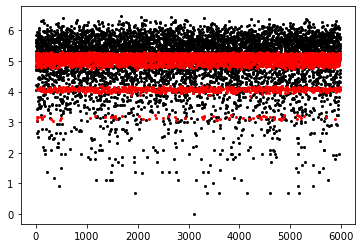

In [135]:
plt.plot(x, y_test, 'o',ms=2,color="k")  #Puntos de datos de entrenamiento en negro
plt.plot(x, prediccionPCA, 'o',ms=2,color="r")  #Puntos de datos de entrenamiento en negro


In [129]:
#PLS

pls = PLSRegression(n_components=nComponentesElegidas)
pls.fit(x_train, y_train)
prediccionPLS=pls.predict(x_test)
prediccionPLS=np.hstack(prediccionPLS)
MSEPLS=np.average(np.square(prediccionPLS-y_test))
print('MSE regresión por partial least squares:')
print(MSEPLS**0.5)

MSE regresión por partial least squares:
0.8004610118461845


In [130]:
#Modelo con penalizacion tipo Ridge
n_alphas = 200
alphasCalibrar = np.logspace(-10, 2, n_alphas)
modeloRidge = RidgeCV(alphas=alphasCalibrar,store_cv_values=True).fit(x_train, y_train)

prediccionRidge=modeloRidge.predict(x_test)
MSERidge=np.average(np.square(prediccionRidge-y_test))
print('MSE regresión con penalización tipo Ridge:')
print(MSERidge**0.5)

MSE regresión con penalización tipo Ridge:
0.8004583175867271


In [131]:
#Modelo con penalizacion tipo LASSO
n_alphas = 200
alphasCalibrar = np.logspace(-10, 2, n_alphas)
modeloLASSO = LassoCV(alphas=alphasCalibrar).fit(x_train, y_train)

prediccionLASSO=modeloLASSO.predict(x_test)
MSELASSO=np.average(np.square(prediccionLASSO-y_test))
print('MSE regresión con penalización tipo LASSO:')
print(MSELASSO**0.5)

MSE regresión con penalización tipo LASSO:
0.8004606618842243


In [132]:
#Modelo con penalizacion ElasticNet

n_alphas = 200
alphasCalibrar = np.logspace(-10, 2, n_alphas)
modeloElastic = ElasticNetCV(alphas=alphasCalibrar,cv=5, random_state=0).fit(x_train,y_train)

prediccionElastic=modeloElastic.predict(x_test)
MSEElastic=np.average(np.square(prediccionElastic-y_test))
print('MSE regresión con penalización tipo Elastic Net:')
print(MSEElastic**0.5)

MSE regresión con penalización tipo Elastic Net:
0.800457762679778
